Boilerplate Connection Setup
---

In [1]:
%%vertica

SET TIME ZONE 'UTC'

First figure out the most recent transaction we have available for analysis in the data warehouse.

In [2]:
%%vertica -> last_transaction_date_df
SELECT
    MAX(order_timestamp)::DATE AS last_transaction_date
FROM
    finance.f_orderitem_transactions f
WHERE
    f.transaction_type IS NOT NULL
    AND f.order_username IS NOT NULL
    AND f.partner_short_code = 'edx'

In [3]:
import datetime
from dateutil.tz import tzutc

alpha = 0.3
effect_size = 0.2
power = 0.8
experiment_id = 8416329705
experiment_start = datetime.datetime(2017, 6, 13, 0, tzinfo=tzutc())
experiment_end_time = datetime.datetime(2017, 6, 20, 15, tzinfo=tzutc())

last_transaction_date = last_transaction_date_df.loc[0][0]
transaction_cutoff = datetime.datetime(
    last_transaction_date.year, last_transaction_date.month, last_transaction_date.day, 0, tzinfo=tzutc()
)

First grab all experiment views and put them in a table. Note that the "Experiment Viewed" event is fired when the experiment is paused, so we hardcode in the time we paused the experiment here.

In [4]:
# %%vertica (experiment_id, experiment_end_time)
# CREATE TABLE IF NOT EXISTS ret.experiment_views
# (
#     received_at TIMESTAMPTZ,
#     timestamp TIMESTAMPTZ,
#     anonymous_id VARCHAR,
#     raw_user_id VARCHAR,
#     user_id INT,
#     experiment_id INT,
#     experiment_name INT,
#     variation_id INT,
#     variation_name INT,
#     course_id VARCHAR,
#     path VARCHAR,
#     url VARCHAR
# );

# INSERT INTO ret.experiment_views
# SELECT
#     event.received_at::TIMESTAMPTZ,
#     event.timestamp::TIMESTAMPTZ,
#     event.anonymous_id,
#     event.user_id AS raw_user_id,
#     CASE
#         WHEN REGEXP_LIKE(event.user_id, '^\d+$') THEN event.user_id::INT
#         ELSE NULL
#     END AS user_id,
#     event.experimentid::INT AS experiment_id,
#     event.experimentname AS experiment_name,
#     event.variationid::INT AS variation_id,
#     event.variationname AS variation_name,
#     CASE 
#         WHEN STRPOS(event.path, '%') = 0
#             THEN REGEXP_SUBSTR(event.path, '/courses/([^/+]+(/|\+)[^/+]+(/|\+)[^/?]+)/', 1, 1, '', 1)
#         ELSE URI_PERCENT_DECODE(
#             REGEXP_SUBSTR(event.path, '/courses/([^/+]+(/|\+)[^/+]+(/|\+)[^/?]+)/', 1, 1, '', 1)
#         )
#     END AS course_id,
#     event.path,
#     event.url
# FROM
#     experimental_events_run14.event_records event
# LEFT JOIN ret.experiment_views AS ev ON
#         ev.received_at = event.received_at :: TIMESTAMPTZ
#     AND ev.timestamp = event.timestamp :: TIMESTAMPTZ
#     AND ev.raw_user_id = event.user_id
#     AND ev.experiment_id = event.experimentid
#     AND ev.variation_id = event.variationid
#     AND ev.course_id = event.course_id
# WHERE
#         event_type = 'Experiment Viewed'
#     AND event.experimentid = :experiment_id
#     AND event.received_at::TIMESTAMPTZ < :experiment_end_time::TIMESTAMPTZ
#     AND ev.experiment_id IS NULL
# ;

# Check for users that saw multiple variations

Check how many users saw multiple variations within the same course, we will exclude these enrollments from our significance calculation.

In [5]:
%%vertica (experiment_id) -> variations_per_user
SELECT
    user_id,
    course_id,
    MIN(variation_name) AS variation_name,
    COUNT(DISTINCT variation_name) AS variations_per_enrollment
FROM
    ret.experiment_views
WHERE
    experiment_id = :experiment_id
GROUP BY 1, 2

In [6]:
num_users = variations_per_user.groupby('variations_per_enrollment').count()
total_users = num_users.user_id.sum()
num_users['percent_of_population'] = (num_users.user_id / float(total_users)) * 100
num_users[['user_id', 'percent_of_population']]

,user_id,percent_of_population
variations_per_enrollment,,
1,217096,93.099130
2,14495,6.216015
3,1597,0.684855


It looks like roughly 93% of our users only saw one variation. Let's remove the other 7% from our analysis.

In [7]:
variations_per_user[variations_per_user.variations_per_enrollment == 1].groupby('variation_name').count()[['user_id']]

,user_id
variation_name,
Fixed Footer,72295
Hero,71736
Original,73065


Just checking, it looks like even when we remove the users that saw multiple variants per course, the group sizes are roughly equivalent.

## Bookings and conversions by user and test group

In [8]:
%%vertica (transaction_cutoff, experiment_id, experiment_end_time) -> conversions

-- This query should return one record per enrollment.
SELECT
    viewed.user_id,
    viewed.course_id,
    viewed.variation_name,
    course.pacing_type,
    purchased.purchase_time,
    COALESCE(purchased.cnt_sales, 0) AS cnt_sales,
    COALESCE(purchased.net_bookings, 0)::FLOAT AS net_bookings,
    COALESCE(purchased.gross_bookings, 0)::FLOAT AS gross_bookings,
    COALESCE(purchased.gross_refunds, 0)::FLOAT AS gross_refunds,
    COALESCE(purchased.cnt_sales, 0)::FLOAT AS cnt_sales,
    COALESCE(purchased.cnt_refunds, 0)::FLOAT AS cnt_refunds
FROM

-- This subquery gathers all enrollments who have been exposed to exactly one variant
(
    SELECT
        user_id,
        course_id,
        MIN(variation_name) AS variation_name,
        MIN(received_at) AS exposure_time
    FROM
        ret.experiment_views
    WHERE
        experiment_id = :experiment_id
    GROUP BY 1, 2
    HAVING COUNT(DISTINCT variation_name) = 1
) AS viewed

-- Need to join with d_user to get their username
JOIN production.d_user du ON du.user_id = viewed.user_id

-- Need to join with d_course to get the pacing_type for the course
JOIN production.d_course course ON course.course_id = viewed.course_id

-- Now join with our finance table to find all sales and refunds for this user that are *after* the first exposure
LEFT JOIN
(
    -- This gathers all transactions associated with an enrollment and pins them to the first transaction time.
    -- This should return one record per enrollment.
    SELECT
        f.order_username AS username,
        f.order_course_id AS course_id,
        MIN(f.order_timestamp)::TIMESTAMPTZ AS purchase_time,
        SUM(f.transaction_amount_per_item) AS net_bookings,
        SUM(CASE WHEN f.transaction_type = 'sale' THEN f.transaction_amount_per_item ELSE 0 END) AS gross_bookings,
        SUM(CASE WHEN f.transaction_type = 'refund' THEN f.transaction_amount_per_item ELSE 0 END) AS gross_refunds,
        SUM(CASE WHEN f.transaction_type = 'sale' THEN 1 ELSE 0 END) AS cnt_sales,
        SUM(CASE WHEN f.transaction_type = 'refund' THEN 1 ELSE 0 END) AS cnt_refunds
    FROM
        finance.f_orderitem_transactions f
    WHERE
        f.transaction_type IS NOT NULL
        AND f.order_username IS NOT NULL
        AND f.partner_short_code = 'edx'
    GROUP BY
        1, 2
) AS purchased
    ON  du.user_username = purchased.username
    AND viewed.course_id = purchased.course_id
    AND purchased.purchase_time BETWEEN viewed.exposure_time AND :transaction_cutoff

In [9]:
a = conversions.groupby(['user_id', 'course_id']).size()
assert len(a[a > 1]) == 0, 'There should be exactly one record per enrollment'

In [10]:
import pandas as pd

conversions['verified_during_treatment'] = conversions.purchase_time < experiment_end_time
conversions['verified_after_treatment'] = conversions.purchase_time > experiment_end_time
conversions['verified'] = ~pd.isnull(conversions.purchase_time)

conversions['gross_bookings_during_treatment'] = conversions.gross_bookings.where(conversions.verified_during_treatment, other=0.0)
conversions['gross_bookings_after_treatment'] = conversions.gross_bookings.where(conversions.verified_after_treatment, other=0.0)

In [11]:
import edx_stats
import edx_plot
from plotnine import *
from IPython.display import display

def compute(converted_col, title):
    conversions_conf_intervals = edx_stats.grouped_confidence_intervals(
        conversions.reset_index(),
        variant_col='variation_name',
        value_col=converted_col,
        ctrl_name='Original',
        group_cols=['pacing_type'],
    )
    display(
        ggplot(conversions_conf_intervals.reset_index(), aes(
            x='variation_name',
            y='percent_change',
            ymin='lower_bound',
            ymax='upper_bound',
            color='significant',
            label_size=0.5,
        ))
        + facet_grid("pacing_type ~ .")
        + edx_plot.geom_confidence()
        + edx_plot.theme_confidence()
        + ggtitle(title)
    )
    return conversions_conf_intervals

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Widget Javascript not detected.  It may not be installed or enabled properly.


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


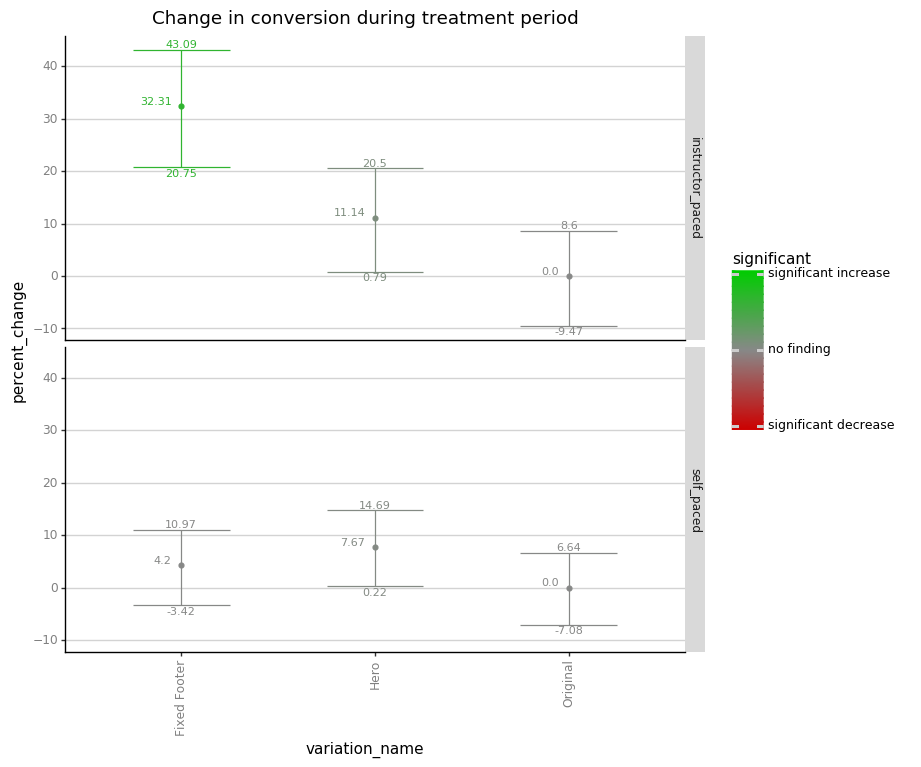

<ggplot: (8764957739861)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer      20.749011       32.314235    43.092974   
                 Hero               0.791155       11.143492    20.499771   
                 Original          -9.467681        0.000000     8.603963   
self_paced       Fixed Footer      -3.418905        4.197929    10.967775   
                 Hero               0.216125        7.665421    14.685087   
                 Original          -7.077981        0.000000     6.638374   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.642101  
                 Hero               0.070997  
                 Original           0.000000  
self_paced       Fixed Footer       0.000000  
                 Hero               0.028195  
                 Original           0.000000

In [12]:
compute(
    'verified_during_treatment',
    'Change in conversion during treatment period'
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


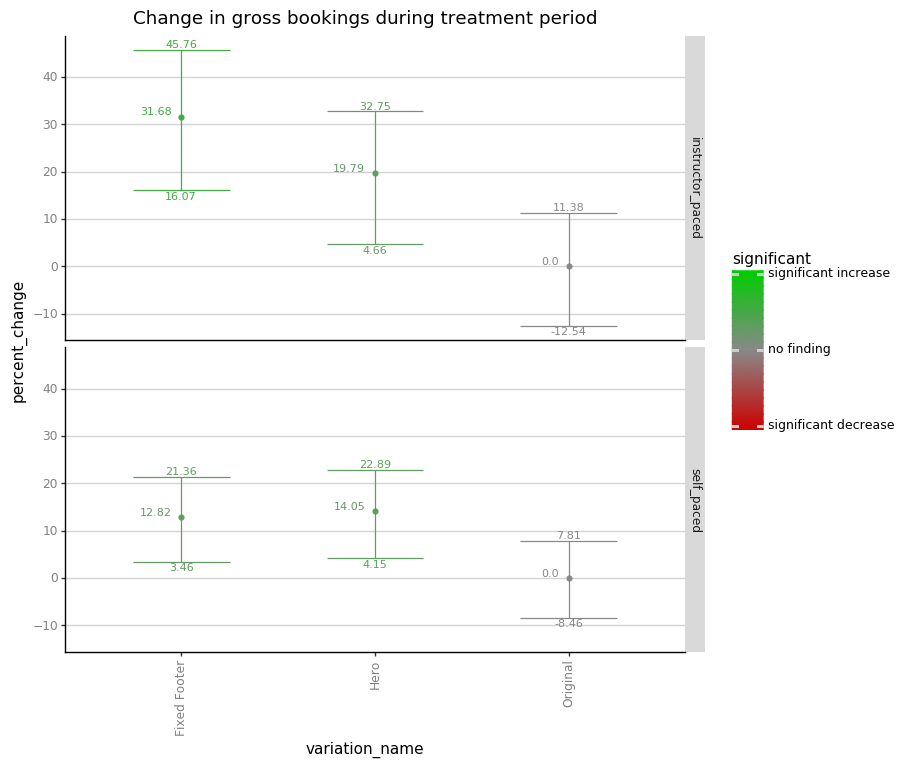

<ggplot: (-9223363271900590055)>

In [13]:
compute(
    'gross_bookings_during_treatment',
    'Change in gross bookings during treatment period'
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


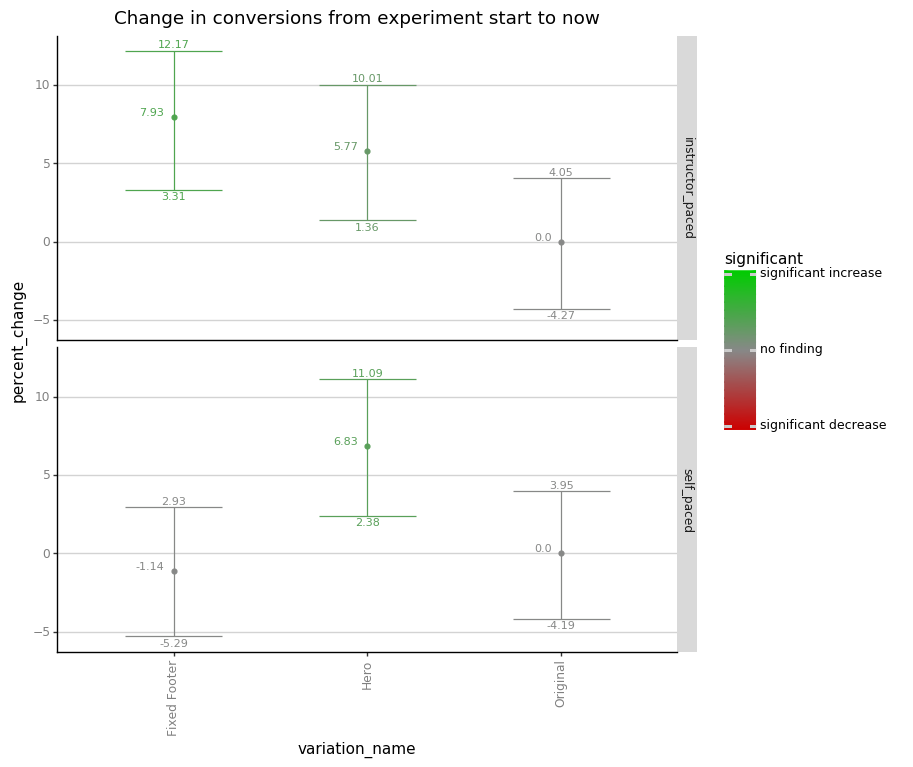

<ggplot: (-9223363271900772506)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer       3.310907        7.928368    12.172708   
                 Hero               1.362705        5.770284    10.010183   
                 Original          -4.268293        0.000000     4.047370   
self_paced       Fixed Footer      -5.291096       -1.143809     2.934319   
                 Hero               2.383249        6.826911    11.091599   
                 Original          -4.185184        0.000000     3.947856   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.417603  
                 Hero               0.236159  
                 Original           0.000000  
self_paced       Fixed Footer       0.000000  
                 Hero               0.349096  
                 Original           0.000000

In [14]:
compute(
    'verified',
    'Change in conversions from experiment start to now'
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


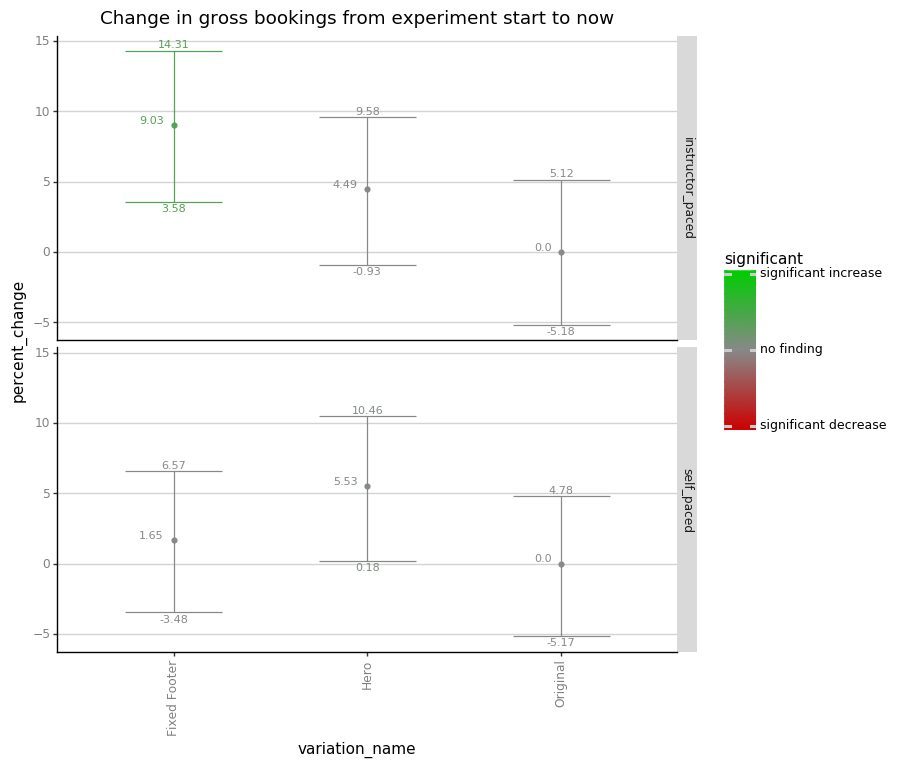

<ggplot: (-9223363271901075922)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer       3.583080        9.029855    14.310319   
                 Hero              -0.934336        4.485453     9.579101   
                 Original          -5.178350        0.000000     5.119261   
self_paced       Fixed Footer      -3.479652        1.652950     6.569354   
                 Hero               0.176726        5.526936    10.464977   
                 Original          -5.168791        0.000000     4.777397   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.396804  
                 Hero               0.000000  
                 Original           0.000000  
self_paced       Fixed Footer       0.000000  
                 Hero               0.031975  
                 Original           0.000000

In [15]:
compute(
    'gross_bookings',
    'Change in gross bookings from experiment start to now'
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


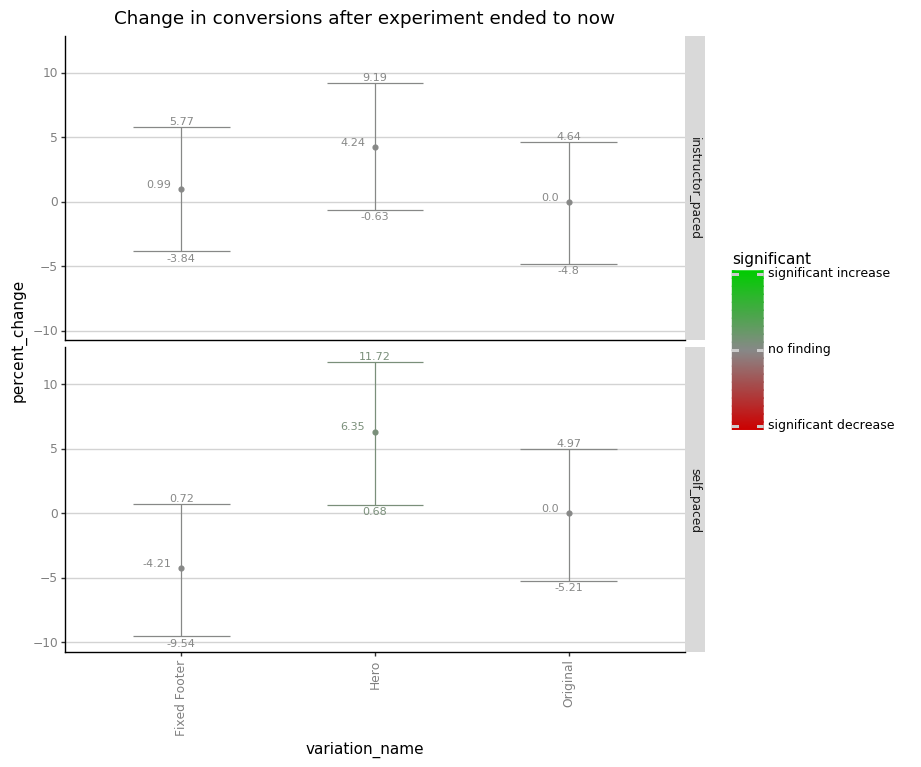

<ggplot: (8764951478343)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer      -3.843083        0.991705     5.769950   
                 Hero              -0.629170        4.241852     9.193921   
                 Original          -4.803493        0.000000     4.640954   
self_paced       Fixed Footer      -9.538612       -4.212906     0.719258   
                 Hero               0.680854        6.345146    11.719381   
                 Original          -5.207151        0.000000     4.969057   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer       0.000000  
                 Hero               0.000000  
                 Original           0.000000  
self_paced       Fixed Footer       0.000000  
                 Hero               0.107303  
                 Original           0.000000

In [16]:
compute(
    'verified_after_treatment',
    'Change in conversions after experiment ended to now'
)

Widget Javascript not detected.  It may not be installed or enabled properly.


/app/lib/edx_stats.py:108: PerformanceWarning: indexing past lexsort depth may impact performance.
  ctrl = indexed.loc[ctrl_loc][value_col]


stat_identity
stat_identity
stat_identity
stat_identity
stat_identity


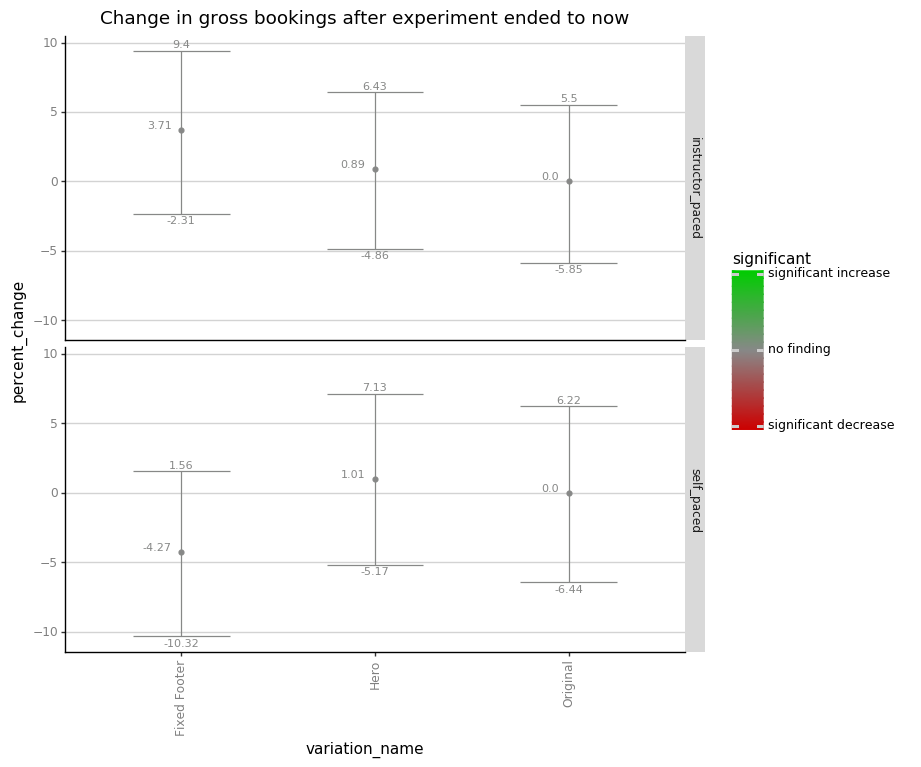

<ggplot: (-9223363271900257799)>

lower_bound  percent_change  upper_bound  \
pacing_type      variation_name                                             
instructor_paced Fixed Footer      -2.314295        3.711879     9.404121   
                 Hero              -4.860703        0.891361     6.431442   
                 Original          -5.845284        0.000000     5.501985   
self_paced       Fixed Footer     -10.322121       -4.268528     1.563943   
                 Hero              -5.174658        1.005738     7.128459   
                 Original          -6.441163        0.000000     6.224702   

                                 significant  
pacing_type      variation_name               
instructor_paced Fixed Footer              0  
                 Hero                      0  
                 Original                  0  
self_paced       Fixed Footer              0  
                 Hero                      0  
                 Original                  0

In [17]:
compute(
    'gross_bookings_after_treatment',
    'Change in gross bookings after experiment ended to now'
)

In [22]:
bookings_conf_intervals = edx_stats.grouped_confidence_intervals(
    conversions.reset_index(),
    variant_col='variation_name',
    value_col='gross_bookings',
    ctrl_name='Original',
)
bookings_by_group = conversions.reset_index().groupby('variation_name').sum().gross_bookings

In [23]:
improvement_range = bookings_conf_intervals.loc['Hero']
baseline_bookings = bookings_by_group.loc['Original']
low = baseline_bookings * (improvement_range.lower_bound / 100)
print(low * 3 * 52)
expected = baseline_bookings * (improvement_range.percent_change / 100)
print(expected * 3 * 52)
high = baseline_bookings * (improvement_range.upper_bound / 100)
print(high * 3 * 52)

526590.656037
1689112.25769
2806891.24681
